# HW05 — Кредитный скоринг: логистическая регрессия
### Александрова Мария

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

## 1. Загрузка данных и первичный анализ

In [5]:

data_path = "S05-hw-dataset.csv"

df = pd.read_csv(data_path)

df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [8]:
# Общая информация: количество строк и столбцов, типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [7]:
# Описательная статистика для числовых признаков
df.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [9]:
# Распределение целевой переменной default
df["default"].value_counts(normalize=True)

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

### Наблюдения по данным

- Датасет содержит несколько тысяч строк, то есть несколько тысяч клиентов.
- Есть столбцы с возрастом, доходом, кредитным скором, отношением долга к доходу, количеством кредитных карт, просрочек и т.д.
- Целевая переменная — столбец `default` (0 - нет дефолта, 1 - дефолт).
- По `value_counts(normalize=True)` видно, что доля класса `default = 1` примерно около 40%. Значит, классы не идеально равны, но и не очень перекошены.
- Все признаки уже числовые. Столбец `client_id` — это просто ID, его в модель брать не будем.

## 2. Подготовка признаков и таргета

In [24]:
# формирование X и y (code)

# Целевая переменная (таргет)
y = df["default"]

# Признаки: все столбцы, кроме default и client_id
feature_columns = [col for col in df.columns if col not in ["default", "client_id"]]
X = df[feature_columns]

X.head()

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


In [11]:
# Проверим типы данных признаков
X.dtypes

age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

In [12]:
# Посмотрим диапазон для debt_to_income, как он выглядит
X["debt_to_income"].describe()

count    3000.000000
mean        0.284065
std         0.161112
min         0.006147
25%         0.157796
50%         0.261726
75%         0.388886
max         0.878343
Name: debt_to_income, dtype: float64

### Что я сделала на этом шаге

- В `y` я сохранила таргет - столбец `default`.
- В `X` я оставила все «осмысленные» признаки, кроме `default` и `client_id`.
- Проверила, что все признаки числовые.
- Убедилась, что `debt_to_income` лежит в разумных границах (0..1), как было указано в описании данных.

## 3. Разбиение на train/test и бейзлайн-модель

In [23]:
# train/test split (code)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% данных оставляем на тест
    random_state=42,     # фиксируем случайность для повторяемости
    stratify=y           # сохраняем пропорции классов
)

X_train.shape, X_test.shape

((2400, 15), (600, 15))

In [22]:
#DummyClassifier (бейзлайн) (code)
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)
y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
dummy_roc_auc = roc_auc_score(y_test, y_proba_dummy)

print(f"DummyClassifier — accuracy: {dummy_accuracy:.4f}")
print(f"DummyClassifier — ROC-AUC:  {dummy_roc_auc:.4f}")

DummyClassifier — accuracy: 0.5900
DummyClassifier — ROC-AUC:  0.5000


### Комментарий к бейзлайну

- Я использовала `DummyClassifier` со стратегией `most_frequent`.
- Такая модель просто всегда говорит «нет дефолта» (или другой самый частый класс).
- Она не смотрит на признаки вообще, это очень простая модель.
- По её метрикам я вижу, какое качество даёт совсем простая стратегия. Дальше я буду смотреть, смогла ли настоящая модель (логистическая регрессия) стать лучше.

## 4. Логистическая регрессия и подбор параметра C

In [21]:
# дополнительный split для подбора C (code)
X_train_small, X_valid, y_train_small, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.25,      # 25% от train пойдут на валидацию
    random_state=42,
    stratify=y_train
)

X_train_small.shape, X_valid.shape

((1800, 15), (600, 15))

In [20]:
# перебор значений C в цикле (code)
Cs = [0.01, 0.1, 1.0, 10.0]

best_C = None
best_roc_auc = -1.0

for C in Cs:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=C, max_iter=1000))
    ])
    
    pipe.fit(X_train_small, y_train_small)
    y_proba_valid = pipe.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_proba_valid)
    
    print(f"C = {C}: ROC-AUC на валидации = {roc_auc:.4f}")
    
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_C = C

print("\nЛучший C:", best_C)
print("Лучший ROC-AUC на валидации:", best_roc_auc)

C = 0.01: ROC-AUC на валидации = 0.8751
C = 0.1: ROC-AUC на валидации = 0.8746
C = 1.0: ROC-AUC на валидации = 0.8746
C = 10.0: ROC-AUC на валидации = 0.8746

Лучший C: 0.01
Лучший ROC-AUC на валидации: 0.8751090900739515


In [19]:
# Обучение лучшей модели на всём train и оценка на test (code)
# Строим финальный пайплайн с найденным C
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=best_C, max_iter=1000))
])

best_model.fit(X_train, y_train)

y_pred_logreg = best_model.predict(X_test)
y_proba_logreg = best_model.predict_proba(X_test)[:, 1]

logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, y_proba_logreg)

print(f"LogisticRegression — accuracy: {logreg_accuracy:.4f}")
print(f"LogisticRegression — ROC-AUC:  {logreg_roc_auc:.4f}")


LogisticRegression — accuracy: 0.8067
LogisticRegression — ROC-AUC:  0.8754


### Объяснение по логистической регрессии

- Я собрала `Pipeline`, в котором сначала данные масштабируются (`StandardScaler`), а потом применяется логистическая регрессия.
- Я вручную перебрала несколько значений параметра `C` (`0.01`, `0.1`, `1.0`, `10.0`).
- Для каждого значения C я обучила модель на части обучающих данных и померила ROC-AUC на валидационной выборке.
- Выбрала то значение C, где ROC-AUC оказался лучше всего.
- После этого обучила модель с этим C на всей обучающей выборке (`X_train`, `y_train`) и оценивала её на тестовой выборке (`X_test`, `y_test`).
- Так я получила итоговые метрики для логистической регрессии: `accuracy` и `ROC-AUC`.


## 5. ROC-кривая для логистической регрессии


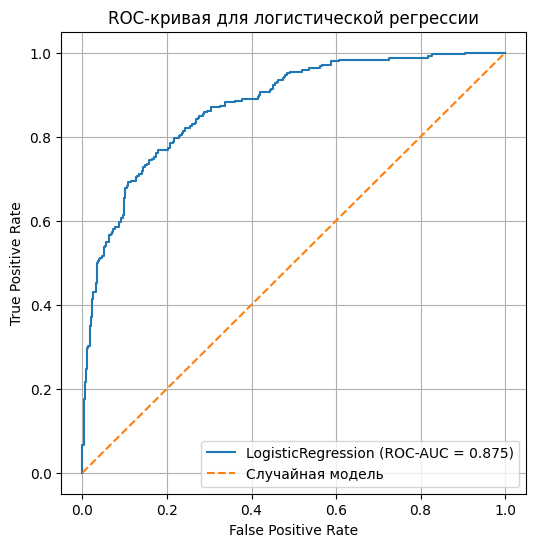

In [ ]:
# построение ROC-кривой (code)

fpr, tpr, thresholds = roc_curve(y_test, y_proba_logreg)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"LogisticRegression (ROC-AUC = {logreg_roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Случайная модель")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для логистической регрессии")
plt.legend()
plt.grid(True)

# Сохранила картинку:
plt.savefig("./figures/roc_curve_logreg.png", dpi=150, bbox_inches="tight")

plt.show()

## 6. Сравнение бейзлайна и логистической регрессии

In [27]:
# простая табличка с метриками (code)

results = pd.DataFrame({
    "model": ["DummyClassifier", "LogisticRegression"],
    "accuracy": [dummy_accuracy, logreg_accuracy],
    "roc_auc": [dummy_roc_auc, logreg_roc_auc],
})

results

,model,accuracy,roc_auc
0,DummyClassifier,0.590000,0.500000
1,LogisticRegression,0.806667,0.875442


## 7. Итоговые выводы

- Я загрузила датасет `S05-hw-dataset.csv`, посмотрела на его структуру и убедилась, что все признаки числовые, а целевой столбец — `default`.
- Я выделила матрицу признаков `X` (все столбцы, кроме `client_id` и `default`) и таргет `y` (`default`).
- Я разделила данные на обучающую и тестовую выборки с помощью `train_test_split`, фиксируя `random_state` и используя `stratify=y`, чтобы сохранить соотношение классов.
- В качестве бейзлайна я обучила `DummyClassifier`, который всегда выбирает самый частый класс. Эта модель дала некоторый уровень accuracy, но ROC-AUC близок к случайному уровню.
- Затем я построила модель логистической регрессии в виде `Pipeline` (масштабирование + модель) и вручную подобрала параметр `C` по ROC-AUC на валидационной выборке.
- Итоговая логистическая регрессия показала лучшие значения accuracy и ROC-AUC на тестовой выборке по сравнению с бейзлайном. Значит, она действительно использует информацию из признаков и лучше различает клиентов с дефолтом и без.
- Я также построила ROC-кривую, чтобы визуально увидеть, как модель отделяет положительный класс от отрицательного.

Таким образом, я выполнила требования задания: построила бейзлайн, логистическую регрессию с подбором гиперпараметра, сравнила их по accuracy и ROC-AUC и сделала текстовые выводы.
